In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from astropy.visualization import make_lupton_rgb
import matplotlib as mpl
import matplotlib.ticker as ticker
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import collections
import cv2

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = 16
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
%matplotlib inline

C:\Users\muham\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
#data_asli = np.load("c:/Users/muham/Documents/TA-Tesis/Data/Data_Zoo/Galaxy_zoo.npy")
data_rescaled = np.load("c:/Users/muham/Documents/TA-Tesis/Data/Data_Zoo/Galaxy_zoo_rescaled_142_142.npy")
#data_rescaled = np.load("c:/Users/muham/Documents/TA-Tesis/Data/Data_Zoo/Galaxy_zoo_rescaled_100_100.npy")
#data_asli

In [3]:
data_rescaled.shape

(14060, 142, 142, 3)

In [4]:
def buat_plot_3_filter(data):
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    axes[0].imshow(data)
    axes[1].imshow(data[:,:,0])
    axes[2].imshow(data[:,:,1])
    axes[3].imshow(data[:,:,2])
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    #plt.savefig('sample.png')
    plt.show()

In [5]:
data = np.array(data_rescaled)/255

In [6]:
data_trim = data[:, 47:95, 47:95, :]    # trimming data

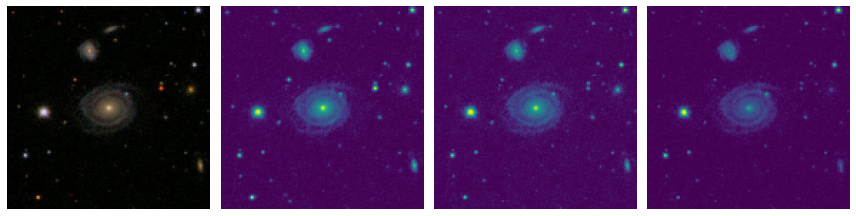

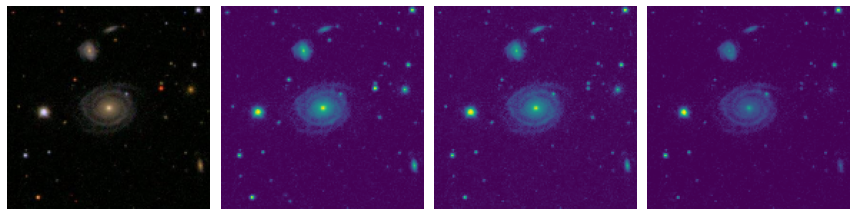

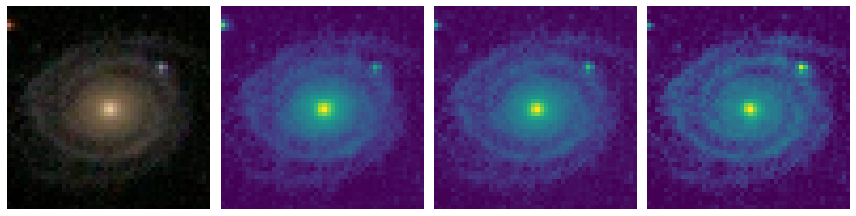

In [7]:
index = 83

buat_plot_3_filter(data[index])
buat_plot_3_filter(data_rescaled[index])
buat_plot_3_filter(data_trim[index])


In [8]:
class Sampling(layers.Layer): 
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [9]:
latent_dim = 100
 
encoder_inputs = keras.Input(shape=(48, 48, 3))
x = layers.Conv2D(8, 3, activation="relu", padding='same')(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, 3, activation="relu", padding='same')(x)
x = layers.Conv2D(64, 3, activation="relu", padding='same')(x)
x = layers.Conv2D(128, 3, activation="relu", padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)                                
x = layers.Dense(256, activation="sigmoid")(x)


mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 16)   1168        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 16)   0           ['conv2d_1[0][0]']               
                                                                                            

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(12 * 12 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((12, 12, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 18432)             1861632   
                                                                 
 reshape (Reshape)           (None, 12, 12, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 12, 12, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 12, 12, 32)       1846

In [11]:
def compute_kernel(x, y):
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

class VAE(keras.Model):
    def __init__(self, encoder, decoder, loss_type="KL", beta=1 , **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type
        self.beta = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.regularization_loss_tracker = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.regularization_loss_tracker,
        ]

    def call(self, inputs):
        mean, log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def compute_mmd(self, x, y):
    
        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)


    def train_step(self, data):
        with tf.GradientTape() as tape:                                  
            mean,log_var,z = self.encoder(data) 
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2),))
                
            if self.loss_type == "KL":
                regularization_loss = -0.5 * self.beta * (1 + log_var - tf.square(mean) - tf.exp(log_var))
                regularization_loss = tf.reduce_mean(tf.reduce_sum(regularization_loss, axis=1)) 
                
            elif self.loss_type == "MMD":

                true_samples = tf.random.normal(tf.shape(z))
                regularization_loss = self.compute_mmd(true_samples, z)
                
            
            total_loss = reconstruction_loss + regularization_loss 
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.regularization_loss_tracker.update_state(regularization_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "regularization_loss": self.regularization_loss_tracker.result(),
        }


# Pemilihan Data

In [14]:
data_trim.shape

(14060, 48, 48, 3)

In [15]:
data = data_trim

vae = VAE(encoder, decoder, loss_type= "MMD")
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(data, epochs=100, batch_size=64)


Epoch 1/100
220/220 [==============================] - 212s 932ms/step - loss: 104.2458 - reconstruction_loss: 39.2199 - regularization_loss: 0.0267
Epoch 2/100
220/220 [==============================] - 207s 943ms/step - loss: 6.6906 - reconstruction_loss: 5.7265 - regularization_loss: 0.0124
Epoch 3/100
220/220 [==============================] - 209s 949ms/step - loss: 4.2236 - reconstruction_loss: 3.9033 - regularization_loss: 0.0082
Epoch 4/100
220/220 [==============================] - 204s 926ms/step - loss: 3.2855 - reconstruction_loss: 3.1720 - regularization_loss: 0.0062
Epoch 5/100
220/220 [==============================] - 204s 926ms/step - loss: 2.9044 - reconstruction_loss: 2.8680 - regularization_loss: 0.0053
Epoch 6/100
220/220 [==============================] - 201s 911ms/step - loss: 2.6502 - reconstruction_loss: 2.5978 - regularization_loss: 0.0047
Epoch 7/100
220/220 [==============================] - 204s 929ms/step - loss: 2.4842 - reconstruction_loss: 2.4400 - reg

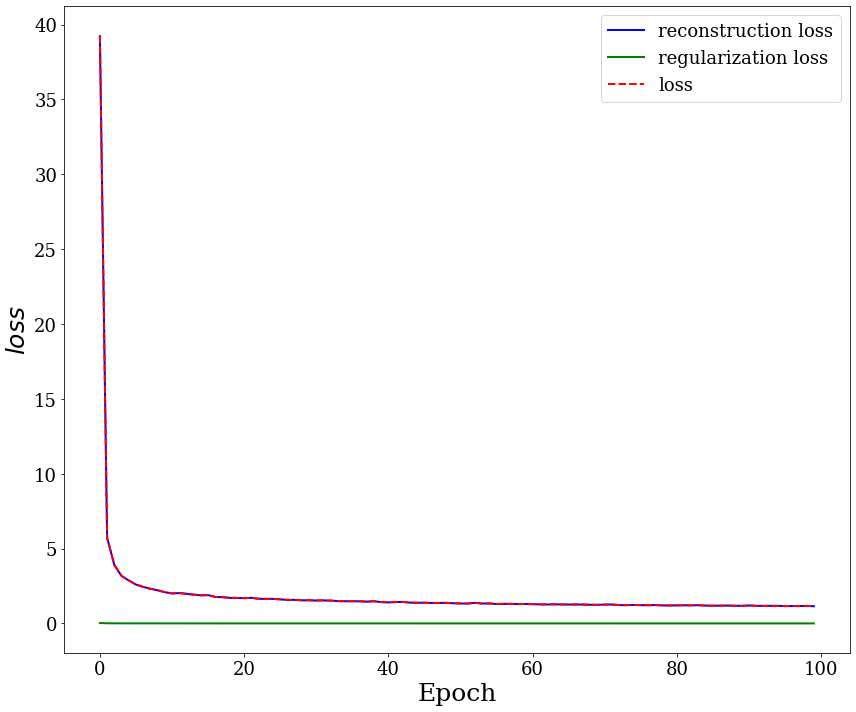

In [16]:
LOSS = history.history["loss"]
rec_loss = history.history["reconstruction_loss"]
reg_loss = history.history["regularization_loss"]

%matplotlib inline

fig = plt.figure(figsize=(12, 10))
plt.plot(rec_loss, label="reconstruction loss", lw=2, ls='-', c='b')
plt.plot(reg_loss, label="regularization loss", lw=2, ls='-', c='g')
plt.plot(LOSS, label="loss", lw=2, ls='--', c='r')
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=25)
plt.ylabel('$loss$', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()

In [17]:
data.shape

(14060, 48, 48, 3)

1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


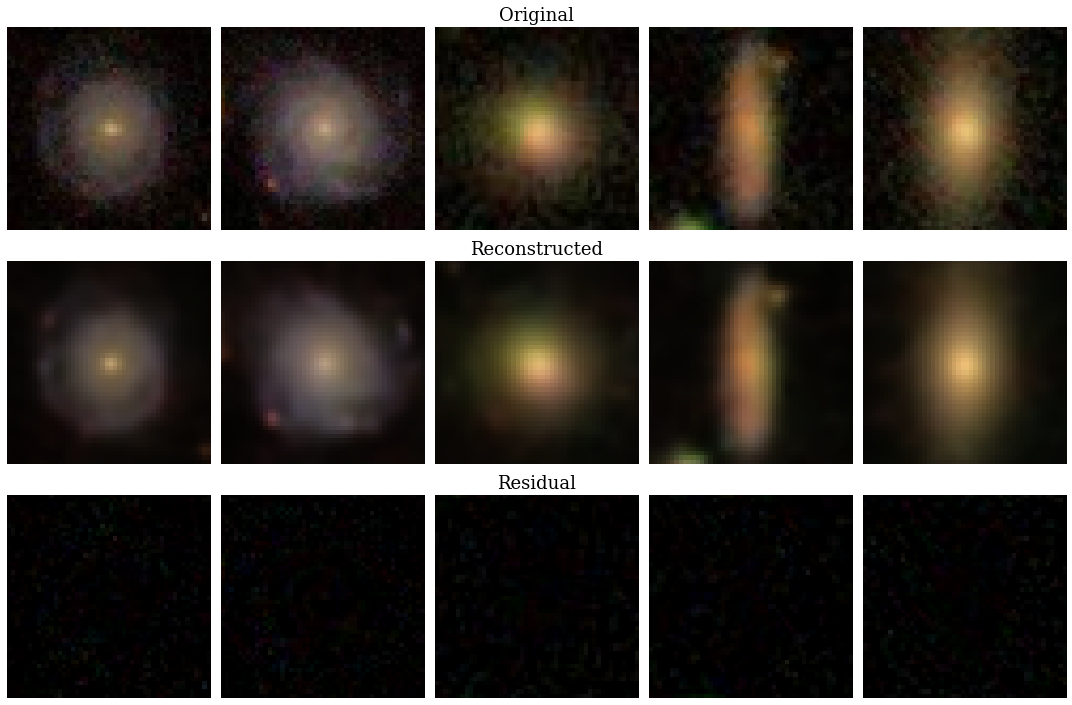

In [22]:
def plot_reconstructed_images(vae, data, n):
    indices = np.random.choice(len(data), n, replace=False)
    samples = data[indices]

    encoded = vae.encoder.predict(samples)
    z = encoded[2] 
    reconstructed = vae.decoder.predict(z)

    fig, axes = plt.subplots(3, n, figsize=(n*3,10))

    for i in range(n):
        axes[0, i].imshow(samples[i], cmap='gray')
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructed[i], cmap='gray')
        axes[1, i].axis("off")

        residual = samples[i] - reconstructed[i]
        axes[2, i].imshow(residual, cmap='seismic')
        axes[2, i].axis("off")

    axes[0, 2].set_title("Original", fontsize=18)
    axes[1, 2].set_title("Reconstructed", fontsize=18)
    axes[2, 2].set_title("Residual", fontsize=18)

    plt.tight_layout()
    plt.show()
    
plot_reconstructed_images(vae, data, n=5)
